# Text Analytics (Group 3)

## Packages

In [1]:
#Install pachages if needed

#!pip3 install --upgrade afinn
#!pip3 install --upgrade textblob
#!pip3 install --upgrade vaderSentiment
#!pip install NRCLex
#!pip install DateTimeRange
#! pip install --user --upgrade  ipywidgets matplotlib
#! jupyter nbextension enable --py widgetsnbextension

In [2]:
from datetime import datetime
from afinn import Afinn
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud 
from PIL import Image
from collections import Counter
from datetimerange import DateTimeRange
from ipywidgets import widgets, interactive, Layout
import ipywidgets as widgets
import os
import glob
import json
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import itertools

## Loading Data (05/26 to 06/30)

In [3]:
#Loading all the json file (Do not add any other unnecessary files inside the'data' folder 'Data' folder except additional json file)
file = glob.glob("{}/Data/*.json".format(os.getcwd()))

tweet = []

for i in range(len(file)):
    with open(file[i], "r", encoding='cp866') as input_file:
        data = input_file.read()
        structure = json.loads(data)
        tweet.extend(structure)

In [4]:
#Convert it to pandas data frame
tweet_df = pd.DataFrame.from_dict(tweet)
tweet_df

print("Twitter data frame with {} rows and {} columns has been loaded".format(len(tweet_df), len(tweet_df.columns)))

Twitter data frame with 104970 rows and 7 columns has been loaded


## Preprocessing

In [5]:
#Checking null values
null_value = tweet_df.isnull().any(axis=1)
tweet_df[null_value]

#According to the code, there's no null values

,id,screen_name,user_id,time,link,text,source


In [6]:
#Changing date time format into valid format (preparing for time-series analysis)
tweet_df["time"] = [pd.to_datetime(s) for s in tweet_df.time]
tweet_df["time"] = [str(s) for s in tweet_df.time]
tweet_df.time=[re.sub("-04:00", "", s) for s in tweet_df.time]
tweet_df.time=[s[:20] for s in tweet_df.time]
tweet_df["time"] = [datetime.strptime(s,'%Y-%m-%d %H:%M:%S') for s in tweet_df.time]

## Most common words

In [7]:
#Most common words
tweet_df.text=[re.sub('https://\S+', "", s) for s in tweet_df.text]
tweet_df.text=[re.sub("http://\S+", "", s) for s in tweet_df.text]
tweet_df.text=[re.sub("RT", "", s) for s in tweet_df.text]
tweet_df.text=[re.sub("amp", "", s) for s in tweet_df.text]

#Tokenize text column
words_all = [nltk.word_tokenize(s) for s in tweet_df["text"]]
words_all = list(itertools.chain.from_iterable(words_all))
#convert to lower case
words_all = [s.lower() for s in words_all]
#Remove stop words
global_stopwords = nltk.corpus.stopwords.words("english")
words_all = [s for s in words_all if s not in global_stopwords]
#Remove short words
words_all = [s for s in words_all if len(s)>2]
#Stemming
stemmer = nltk.stem.SnowballStemmer("english")
words_all = [stemmer.stem(s) for s in words_all]

#Display most common words
counts = Counter(words_all)
counts.most_common(20)

[('american', 14473),
 ('today', 14464),
 ('polic', 14436),
 ('act', 12023),
 ('need', 11596),
 ('work', 11239),
 ('communiti', 10381),
 ('must', 9443),
 ('peopl', 8936),
 ('vote', 8913),
 ('protect', 8886),
 ('help', 8464),
 ('live', 8348),
 ('trump', 8310),
 ('time', 7936),
 ('hous', 7792),
 ('make', 7596),
 ('right', 7554),
 ('nation', 7528),
 ('justic', 7403)]

## Document Representation

In [8]:
#Document representation
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

stemmer = nltk.stem.SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

nltk_stopwords = nltk.corpus.stopwords.words("english") 
vectorizer = CountVectorizer(stop_words=nltk_stopwords)
DTM = vectorizer.fit_transform(tweet_df["text"])

#vectorizer=StemmedTfidfVectorizer(stop_words=nltk_stopwords,
                                  #use_idf=True,
                                  #smooth_idf=True,
                                  #norm=None)

DTM.shape


(104970, 78728)

## 20 Frequent Bigram

In [9]:
#N-gram pairs
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import nltk

stemmer = nltk.stem.SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

nltk_stopwords = nltk.corpus.stopwords.words("english")     
vectorizer=CountVectorizer(stop_words=nltk_stopwords,
                           ngram_range=(2,2))
DTM = vectorizer.fit_transform(tweet_df["text"])

dfTF = pd.DataFrame({'Term': vectorizer.get_feature_names(),
                       'Frequency': DTM.sum(axis=0).tolist()[0]
                       })

dfTF.sort_values(by="Frequency",inplace=True,ascending=False)
dfTF.reset_index(inplace=True,drop=True)
dfTF.head(20)


,Term,Frequency
0,covid 19,5296
1,george floyd,3447
2,law enforcement,2454
3,health care,2213
4,small businesses,2151
5,police brutality,1935
6,supreme court,1788
7,president trump,1660
8,justiceinpolicing act,1561
9,across country,1484


## Bigram visualization

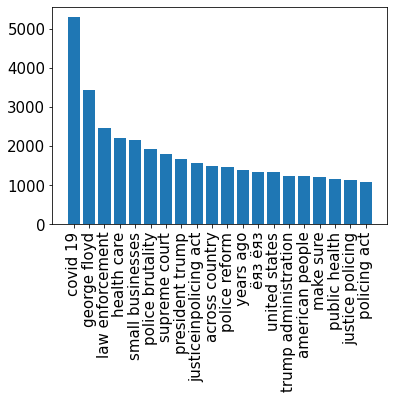

In [10]:
#Top 20 bigram distribution
top = 20                                              
fig, ax = plt.subplots()
ax.bar(dfTF.Term[0:top],dfTF.Frequency[0:top])
plt.rcParams['figure.figsize'] = (24,10)
plt.xticks(rotation=90,fontsize= 15)       
plt.yticks(fontsize= 15)                          
plt.show()

## Sentimental Analysis (AFINN & TextBlob & VADER)

In [11]:
#AFINN
afinn = Afinn(emoticons=True)
tweet_df["AFINN"]=[afinn.score(s) for s in tweet_df.text]

#TextBlob
tweet_df["TextBlob"]=[TextBlob(s).sentiment.polarity for s in tweet_df.text]

#VADER
analyzer=SentimentIntensityAnalyzer()
tweet_df["VADER"]=[analyzer.polarity_scores(s)['compound'] for s in tweet_df.text]

tweet_df.head()

,id,screen_name,user_id,time,link,text,source,AFINN,TextBlob,VADER
0,1273465602557050886,JudiciaryGOP,1131917492,2020-06-18 00:00:34,https://www.twitter.com/JudiciaryGOP/statuses/...,Meanwhile at the New York Times... QT @RichL...,Twitter for iPhone,0.0,0.090909,0.5473
1,1273478875713077248,ericswalwell,377609596,2020-06-18 00:53:18,https://www.twitter.com/donwinslow/statuses/12...,@donwinslow My *NEW* Trump video is here!!\n\...,Twitter for iPhone,-2.0,0.090767,-0.8349
2,1273478626995048448,ChrisMurphyCT,150078976,2020-06-18 00:52:19,https://www.twitter.com/ChrisMurphyCT/statuses...,@brianschatz Roger that.,Twitter for iPhone,0.0,0.000000,0.0000
3,1273477755989090304,PramilaJayapal,193441812,2020-06-18 00:48:51,https://www.twitter.com/PramilaJayapal/statuse...,ЁЯЧгя╕П Abolish qualified immunity.,Twitter Web App,0.0,0.000000,0.0000
4,1273475942376263681,LacyClayMO1,584912320,2020-06-18 00:41:39,https://www.twitter.com/TDucklo/statuses/12288...,@TDucklo My president \n\n,Twitter for iPad,0.0,0.000000,0.0000


## Visualize Time Series Plot

In [12]:
#Visualize time series plot
tweet_df["AFINN_scaled"] = [s/10 for s in tweet_df["AFINN"]]
tweet_df.sort_values(by=["time"],ascending=True,inplace=True)

%matplotlib inline

layout = widgets.Layout(width='auto', height='40px')
dropdown = widgets.Dropdown(
    description='Method:',
    options = ['All', 'AFINN_scaled', 'TextBlob', 'VADER'],  # a sorted list of unique teamIDs plus All
    value = "All",
    style = {"description_width": '50px'},
    layout = layout
)

def view(sentiment):
    if sentiment == "AFINN_scaled":
        plt.figure(figsize=(25,12))
        plt.plot(tweet_df.time, tweet_df.AFINN_scaled.rolling(window=50).mean(), "-g", alpha=0.7, label="AFINN_scaled")
    elif sentiment == "TextBlob":
        plt.figure(figsize=(25,12))
        plt.plot(tweet_df.time, tweet_df.TextBlob.rolling(window=50).mean(), "-b", alpha=0.7, label="TextBlob")
    elif sentiment == "VADER":
        plt.figure(figsize=(25,12))
        plt.plot(tweet_df.time, tweet_df.VADER.rolling(window=50).mean(), "-r", alpha=0.7, label="VADER")
    else:
        plt.figure(figsize=(25,12))
        plt.plot(tweet_df.time, tweet_df.AFINN_scaled.rolling(window=50).mean(), "-g", alpha=0.7, label="AFINN_scaled")
        plt.plot(tweet_df.time, tweet_df.TextBlob.rolling(window=50).mean(), "-b", alpha=0.7, label="TextBlob")
        plt.plot(tweet_df.time, tweet_df.VADER.rolling(window=50).mean(), "-r", alpha=0.7, label="VADER")
        
    plt.legend(loc="upper left")
    plt.title("Sentiment Score of congressman twitter by using {}".format(sentiment))
    plt.xlabel("date")
    plt.ylabel("Sentiment Score (Moving Average with Window Size 50)")
    plt.grid(axis='both')

i = interactive(view, sentiment=dropdown)
display(i)

interactive(children=(Dropdown(description='Method:', layout=Layout(height='40px', width='auto'), options=('Al…

## Word Cloud

In [13]:
#Frequency chart
nltk_stopwords = nltk.corpus.stopwords.words("english") 
vectorizer = CountVectorizer(stop_words=nltk_stopwords)

DTM =vectorizer.fit_transform(tweet_df["text"])
dffreq = pd.DataFrame({'Term': vectorizer.get_feature_names(),
                   'Frequency': DTM.sum(axis=0).tolist()[0]
                  })

dffreq.sort_values(by="Frequency",inplace=True,ascending=False)
dffreq.reset_index(inplace=True,drop=True)
dffreq.head(10)

,Term,Frequency
0,qt,18938
1,today,14477
2,police,11608
3,act,11479
4,must,9482
5,people,8974
6,need,8594
7,trump,8422
8,us,8303
9,americans,7882


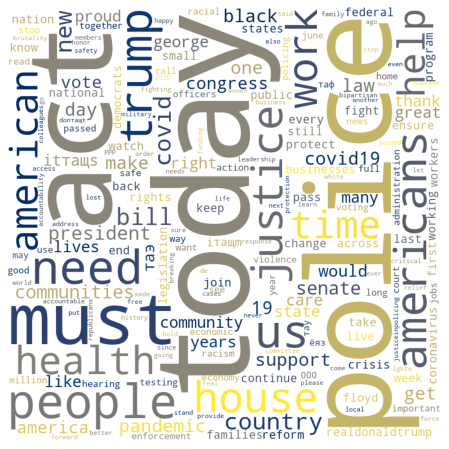

In [14]:
#Creating Word Cloud

dictfreq = dict(zip(dffreq.Term,dffreq.Frequency))
del dictfreq['qt']

#moneybag_mask = np.array(Image.open("classdata/pngwing.com.png")) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                prefer_horizontal=0.9, 
                colormap='cividis',      
                min_font_size = 10).generate_from_frequencies(frequencies=dictfreq) 
plt.figure(figsize = (8, 8)) 
plt.imshow(wordcloud) 
plt.axis("off") 

#Check your answer:
plt.show() 